# CS 4964 - Final Project: Command Word Audio
<div style="text-align: right; font-weight: bold;"> Tyler DeBruin </div>
<div style="text-align: right; font-weight: bold;"> Nolan Angerbauer </div>
<br>
<div style="text-align: right; font-weight: bold;"> 3/28/2024 </div>
<br>


<div style="text-align: center; font-weight: bold;"> Final Project: Command Word Audio </div>

### Abstract

Utilizing Apache Spark, and a Command Word dataset provided by Huggingface.co we will build
and train a machine learning model that can differentiate command words from non-command words, or
silence and white noise. We provide a mechanism to forward audio into the model, and provide inference
on the output command word.


### Dataset
The dataset we will be using is from Huggingface.co. 

Repository: https://huggingface.co/datasets/speech_commands
<br>
As Per HuggingFace:
<br>
##### Language
English (BCP-47 en)
<br>
##### Collection
The audio files were collected using crowdsourcing. The goal was to gather examples of people speaking single-word commands, rather than conversational sentences, so they were prompted for individual words over the course of a five minute session. The dataset consists of people who have donated their voice online. 
<br><br>


In [71]:
import os
import numpy as np
import librosa
import soundfile
from speech_commands import SpeechCommands
from datasets import concatenate_datasets, load_dataset, load_from_disk
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BinaryType, Row, BooleanType
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
spark = SparkSession.builder.master("local[1]") \
    .appName("Postgres") \
    .config("spark.jars", "/final/postgresql-42.7.3.jar") \
    .config("spark.sql.legacy.createHiveTableByDefault", "False") \
    .getOrCreate()

url = "jdbc:postgresql://postgres:5432/cs4964"

properties = {
    "user": "root",
    "password": "password",
    "driver": "org.postgresql.Driver"
}

In [4]:
dataset = load_dataset("speech_commands", "v0.02", keep_in_memory=False, num_proc=2)
dataset.save_to_disk("speechCommands")
dataset = load_from_disk("speechCommands")
dataset = dataset.with_format("torch")

Saving the dataset (0/6 shards):   0%|          | 0/84848 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9982 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4890 [00:00<?, ? examples/s]

In [5]:
training = dataset['train']
validation = dataset['validation']
combinedDataset = concatenate_datasets([training, validation])

In [6]:
training[0]

{'file': 'backward/2356b88d_nohash_0.wav',
 'audio': {'path': '2356b88d_nohash_0.wav',
  'array': tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0001, -0.0002, -0.0001]),
  'sampling_rate': tensor(16000)},
 'label': tensor(30),
 'is_unknown': tensor(True),
 'speaker_id': '2356b88d',
 'utterance_id': tensor(0)}

https://huggingface.co/docs/datasets/en/package_reference/main_classes

In [7]:
"""
fileId = 0
batched = 0
audio_rows = []
command_rows = []
for batch_idx, data in enumerate(dataloader):
    print(data)
    fileId += 1
    batched += 1
    # Process each item in the batch
    command_rows.append(Row(
        fileId=fileId,
        file=data['file'][0],
        label=data['label'].item(),
        is_unknown=data['is_unknown'].item(),
        speaker_id=data['speaker_id'][0],
        utterance_id=data['utterance_id'].item(),
    ))

    audio_rows.append(Row(
        fileid=fileId,
        Audio=np.array(data['audio']['array'][0], dtype=np.int16).tobytes(),
        SamplingRate=data['audio']['sampling_rate'].item()
    ))
    
    # Create DataFrames from the lists of rows

    # Write to PostgreSQL
    if(batched % 100 == 0):

        CommandWords_DF = spark.createDataFrame(command_rows, StructType([
            StructField("fileId", IntegerType(), False),
            StructField("file", StringType(), False),
            StructField("label", IntegerType(), False),
            StructField("is_unknown", BooleanType(), False),
            StructField("speaker_id", StringType(), False),
            StructField("utterance_id", IntegerType(), False)
        ]))
    
        Audio_DF = spark.createDataFrame(audio_rows, StructType([
            StructField("fileid", IntegerType(), False),
            StructField("Audio", BinaryType(), False),
            StructField("SamplingRate", IntegerType(), False),
        ]))


        CommandWords_DF.write.jdbc(url=url, table="AudioFile", mode="append", properties=properties)
        Audio_DF.write.jdbc(url=url, table="AudioBytes", mode="append", properties=properties)
        command_rows.clear()
        audio_rows.clear()
"""

'\nfileId = 0\nbatched = 0\naudio_rows = []\ncommand_rows = []\nfor batch_idx, data in enumerate(dataloader):\n    print(data)\n    fileId += 1\n    batched += 1\n    # Process each item in the batch\n    command_rows.append(Row(\n        fileId=fileId,\n        file=data[\'file\'][0],\n        label=data[\'label\'].item(),\n        is_unknown=data[\'is_unknown\'].item(),\n        speaker_id=data[\'speaker_id\'][0],\n        utterance_id=data[\'utterance_id\'].item(),\n    ))\n\n    audio_rows.append(Row(\n        fileid=fileId,\n        Audio=np.array(data[\'audio\'][\'array\'][0], dtype=np.int16).tobytes(),\n        SamplingRate=data[\'audio\'][\'sampling_rate\'].item()\n    ))\n    \n    # Create DataFrames from the lists of rows\n\n    # Write to PostgreSQL\n    if(batched % 100 == 0):\n\n        CommandWords_DF = spark.createDataFrame(command_rows, StructType([\n            StructField("fileId", IntegerType(), False),\n            StructField("file", StringType(), False),\n       

### Preprocessing

To begin curating the data, we start by finding all data points outside of 16kHz, and resampling those.
That includes both upsampling, and downsampling any audio files.

Arrange: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
Interp: https://numpy.org/doc/stable/reference/generated/numpy.interp.html


##### MelSpectrogram

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

In [82]:
import torchaudio.transforms as T

def preprocess_audio(row):

    #[channel, time]
    #All of our audio files are expected to be [1, 16000]
    waveform = row['audio']['array'].unsqueeze(0)
    
    sampleRate = row['audio']['sampling_rate']

    #print('waveform', waveform.shape, 'sampleRate', sampleRate)
    
    mel_spectrogram_transformer = T.MelSpectrogram(
        sample_rate=sampleRate,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    
    mel_spectrogram = mel_spectrogram_transformer(waveform)

    #print('mel_spectrogram', mel_spectrogram.shape, 'mel_spectrogram_db', mel_spectrogram.shape, 'mel_spectrogram.size(1)', mel_spectrogram.size(1))
    #Pad all of the Spectograms to 32
    if mel_spectrogram.size(2) < 32:
        # Pad the spectrogram
        pad_amount = 32 - mel_spectrogram.size(2)
        mel_spectrogram = F.pad(mel_spectrogram, (0, pad_amount))
    elif mel_spectrogram.size(2) > 32:
        # Truncate the spectrogram
        mel_spectrogram = mel_spectrogram[:, :, :32]


    #Transpose, as Per Hugging Face - [batch, n_mels, time] should be input to the Convolution Neural Network
    mel_spectrogram = mel_spectrogram.transpose(1,2)
    
    #print('mel_spectrogram', mel_spectrogram.shape)
    
    amplitudeToDB = T.AmplitudeToDB()
    
    mel_spectrogram_db = amplitudeToDB(mel_spectrogram)

    #print('spectrogram', mel_spectrogram_db.squeeze(0).shape)
    
    result = {'spectrogram': mel_spectrogram_db.squeeze(0), 'label': row['label'] }
    
    return result

In [83]:
feature_Dataset = dataset.map(preprocess_audio)

Map:   0%|          | 0/84848 [00:00<?, ? examples/s]

Map:   0%|          | 0/9982 [00:00<?, ? examples/s]

Map:   0%|          | 0/4890 [00:00<?, ? examples/s]

In [67]:
def collate(batch):

    spectrograms = torch.stack([item['spectrogram'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return spectrograms, labels

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

In [92]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


tensor([[[-43.7645, -44.3977, -38.5431,  ..., -47.1443, -49.8820, -54.3247],
         [-50.7191, -48.7842, -46.5362,  ..., -51.0459, -54.3404, -57.5443],
         [-51.0567, -45.5311, -40.0511,  ..., -50.5628, -52.6305, -56.9738],
         ...,
         [-57.2877, -55.5646, -51.8088,  ..., -42.6361, -43.9740, -47.2735],
         [-59.1802, -53.4796, -50.8655,  ..., -35.9448, -40.1519, -46.8437],
         [-57.4778, -56.6472, -45.2963,  ..., -39.2529, -40.5663, -47.5111]]])
tensor([16])


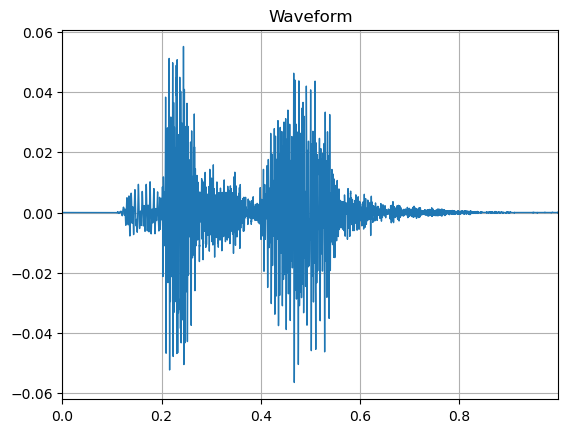

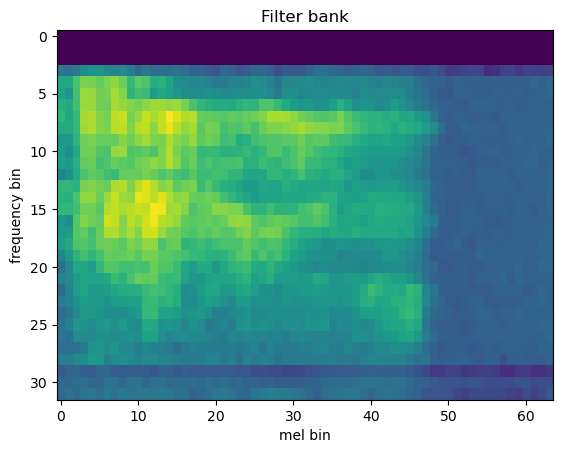

In [102]:
train_DataLoader = DataLoader(feature_Dataset['train'], batch_size=1, shuffle=True, collate_fn=collate)

waveForm = feature_Dataset['train'][0]['audio']['array'].unsqueeze(0)
plot_waveform(waveForm, feature_Dataset['train'][0]['audio']['sampling_rate'])

plot_fbank(preprocess_audio(feature_Dataset['train'][0])['spectrogram'])

for spectrograms, labels in train_DataLoader:
    print(spectrograms) 
    print(labels)
    
    break

### Convolution Neural Network
https://en.wikipedia.org/wiki/Convolutional_neural_network

In [69]:
class CommandWordCNN(nn.Module):
    def __init__(self):
        self.numberOfClasses = 36
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, self.numberOfClasses)  # Number of command words
            
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [104]:
commandWord = CommandWordCNN()

crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(commandWord.parameters(), lr=0.001)

epochs = 10

# Training loop
for epoch in range(epochs): 
    
    for i, (spectogram, labels) in enumerate(train_DataLoader):
        
        optimizer.zero_grad()
        
        outputs = commandWord(spectogram)
        
        loss = crossEntropyLoss(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch + 1}], Step [{i}], Loss: {loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 32768x128)